# Object Detection with TensorFlow Object Detection API

## Learning Objectives 
- Learn how to setup the TensorFlow Object Detection API environment
- Learn how to preprocess datasets for object detection
- Learn how to restore pre-trained weights for transfer learning
- Learn how to run transfer learning 
- Learn how to use trained models and visualize the results.

In this lab, you will learn how to apply transfer learning using [TensorFlow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).

If we build an object detection program from scratch, we need to write a complex model, preprocessing and postprocessing codes, and multiple loss functions.<br>
TensorFlow Object Detection API provides useful tools to speed up the building process.

In this notebook, we will retrieve a pre-trained model architecture and its weights and run transfer learning using our own dataset.

## Environment Setup

We can install Object Detection API directly, but here let's create a separate kernel environment to avoid affecting the other notebook execution.

The script is prepared in [asl-ml-immersion/kernels/object_detection.sh](../../../kernels/object_detection.sh), and you can build the kernel from the `make` command below.

This command executes the following operations:
- Setup virtual env and create a new Jupyter Notebook kernel
- Download the Object Detection API module from GitHub
- Install the necessary dependencies of the Object Detection API

In [ ]:
!cd ~/asl-ml-immersion && make object_detection_kernel

After running the command above, change the kernel of this notebook to `object_detection_kernel` and continue to run from the next cell.

1. Select the kernel section on the top. (`Python 3` is the default kernel name)
> <img width="1039" alt="image" src="https://user-images.githubusercontent.com/6895245/196198001-681184a4-a289-4352-b137-f66697673d55.png">

2. Select `object_detection_kernel`
> <img width="316" alt="image" src="https://user-images.githubusercontent.com/6895245/196198300-4447a928-52c5-41a3-b3a6-63265b5791a9.png">


## Import Libraries
Note that we import some modules from Object Detection API.

In [1]:
import io
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from object_detection.builders import model_builder
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline

2022-10-19 07:11:01.684631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 07:11:02.059704: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-19 07:11:02.833959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-10-19 07:11:02.834051: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer

## Data Preprocessing
Here let's create a data loader for [`salad.csv`](../dataset_import_files/salads.csv) dataset which is created for AutoML Object Detection.

In this dataset, all the rows are organized in `path, label, x_min, y_min, , ,x_max,y_max,,`
- `path`: the path to the image file
- `label`: a label for a bounding box
- `x_min`, `y_min`, `x_max`, `y_max`: coordinates of the boundig box rectangle.

In [2]:
CSV_PATH = "../dataset_import_files/salads.csv"
!head $CSV_PATH

gs://cloud-ml-data/img/openimage/103/279324025_3e74a32a84_o.jpg,Baked Goods,0.005743,0.084985,,,0.567511,0.735736,,
gs://cloud-ml-data/img/openimage/103/279324025_3e74a32a84_o.jpg,Salad,0.402759,0.310473,,,1.000000,0.982695,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.000000,0.000000,,,0.054865,0.480665,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.041131,0.401678,,,0.318230,0.785916,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.116263,0.065161,,,0.451528,0.286489,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.557359,0.411551,,,0.988760,0.731613,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.562206,0.059401,,,0.876467,0.260982,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.567861,0.000161,,,0.699543,0.077502,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.916052,0.085569,,,1.0

Note that each image has multiple rows for multiple bouding boxes. In order to use this dataset in Object Detection API, we will need to preprocess this and aggregate them later.

First, we create unique image list (`PATHS`) and unique class labels (`CLASSIS`) using pandas dataframe. And then define lookup tables with [`StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) module. 

In [3]:
df = pd.read_csv(CSV_PATH)
PATHS = df.iloc[:, 0].unique()
CLASSES = df.iloc[:, 1].unique()

In [4]:
img_id_lookup = tf.keras.layers.StringLookup(vocabulary=PATHS)
class_lookup = tf.keras.layers.StringLookup(vocabulary=CLASSES)

2022-10-19 07:11:06.052986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 07:11:06.066171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 07:11:06.067936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 07:11:06.070701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Read CSV and create dataset

Next, we define tf.data pipeline to:
1. Load and parse CSV data
2. Aggregate multiple rows (bouning boxes) into lists by image paths as keys
3. Load the image path and decode the jpeg file into Tensor
4. Split data into training and test dataset

#### 1. Load and Parse CSV data

In [5]:
def parse_csv(row):
    row = tf.strings.split(row, ",")
    path = row[0]
    label = row[1]
    one_hot_label = class_lookup(label)
    sbox = tf.gather(
        row, [3, 2, 7, 6]
    )  # Reorder to: y_min, x_min, y_max, x_max
    bbox = tf.strings.to_number(sbox)
    return path, one_hot_label, bbox


data = tf.data.TextLineDataset(CSV_PATH).map(parse_csv)

#### 2. Aggregate bounding boxes
Group multiple rows by using image paths as keys. 

We can use [`Dataset.group_by_window`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#group_by_window) to achieve this.

For this method, we need to specify which feature we use as aggregation key (`key_func`), how to aggregate other features (`reduce_func`), and the max window size to aggregate (`window_size`).<br>
In this `salad.csv` case:
- Key: ID of Paths
- Aggregation: combine in lists (`Dataset.batch`)
- Window Size: the max number of the bounding boxes in one image. 50 should be enough for this dataset as no image has more than 50 object.

In [6]:
WINDOW_SIZE = 50
SEED = 3

data = data.group_by_window(
    key_func=lambda path, label, bbox: img_id_lookup(path),
    reduce_func=lambda _, window: window.batch(WINDOW_SIZE),
    window_size=WINDOW_SIZE,
).shuffle(len(PATHS), seed=SEED)

#### 3. Load image path and decode jpeg file
Define image loader and decoder.

In [7]:
def decode_jpg(path, label, bbox):
    img = tf.io.read_file(path[0])
    img = tf.io.decode_jpeg(img, channels=3)
    return path[0], img, label, bbox


data = data.map(decode_jpg)

#### 4. Split data
Split the preprocessed data into training (80%) and test (20%) datasets.

In [8]:
TRAIN_SIZE = int(len(PATHS) * 0.8)

train_data = data.take(TRAIN_SIZE)
test_data = data.skip(TRAIN_SIZE)

Let's retrieve and take a look at the preprocessing result.

In [9]:
for path, img, label, bbox in train_data.take(1):
    print(f"path: {path}")
    print(f"img shape: {img.shape}")
    print(f"label (index): {label}")
    print(f"bbox (x_min, y_min, x_max, y_max): {bbox}")

    print("*" * 50)
    # Check the number of bounding boxes.
    assert label.shape[0] == bbox.shape[0]
    print(f"This image has {label.shape[0]} bounding boxes")

path: b'gs://cloud-ml-data/img/openimage/5/4009/4589206559_5d6f49fd94_o.jpg'
img shape: (666, 1000, 3)
label (index): [1 3 4 4 4 4 4]
bbox (x_min, y_min, x_max, y_max): [[0.111368 0.106359 0.890294 0.843813]
 [0.152102 0.12629  0.843742 0.815577]
 [0.628436 0.229268 0.738167 0.35107 ]
 [0.202811 0.335568 0.288435 0.460138]
 [0.641736 0.414739 0.806333 0.490588]
 [0.241882 0.607961 0.342469 0.691561]
 [0.513716 0.691007 0.584377 0.735853]]
**************************************************
This image has 7 bounding boxes


Now we can see multiple bounding boxes and labels are successfully linked to one image.

## Visualize Training Data
Let's visualize the preprocessed dataset using Object Detection API helper functions.

In [10]:
def plot_detections(image_np, boxes, classes, scores, category_index):
    image_np_with_annotations = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.4,
        line_thickness=20,
    )

    plt.imshow(image_np_with_annotations)

This helper function requires the class mapping dictionary to assign different colors to each bounding box.

In [11]:
category_index = {
    i: {"id": i, "name": class_name}
    for i, class_name in enumerate(class_lookup.get_vocabulary())
    if class_name != "[UNK]"
}
category_index

{1: {'id': 1, 'name': 'Salad'},
 2: {'id': 2, 'name': 'Cheese'},
 3: {'id': 3, 'name': 'Seafood'},
 4: {'id': 4, 'name': 'Tomato'},
 5: {'id': 5, 'name': 'Baked Goods'}}

Now we can call this function and check some samples from the training dataset.<br>
We assign `1` (100%) for the confidence scores as the bounding boxes are ground truth labels.

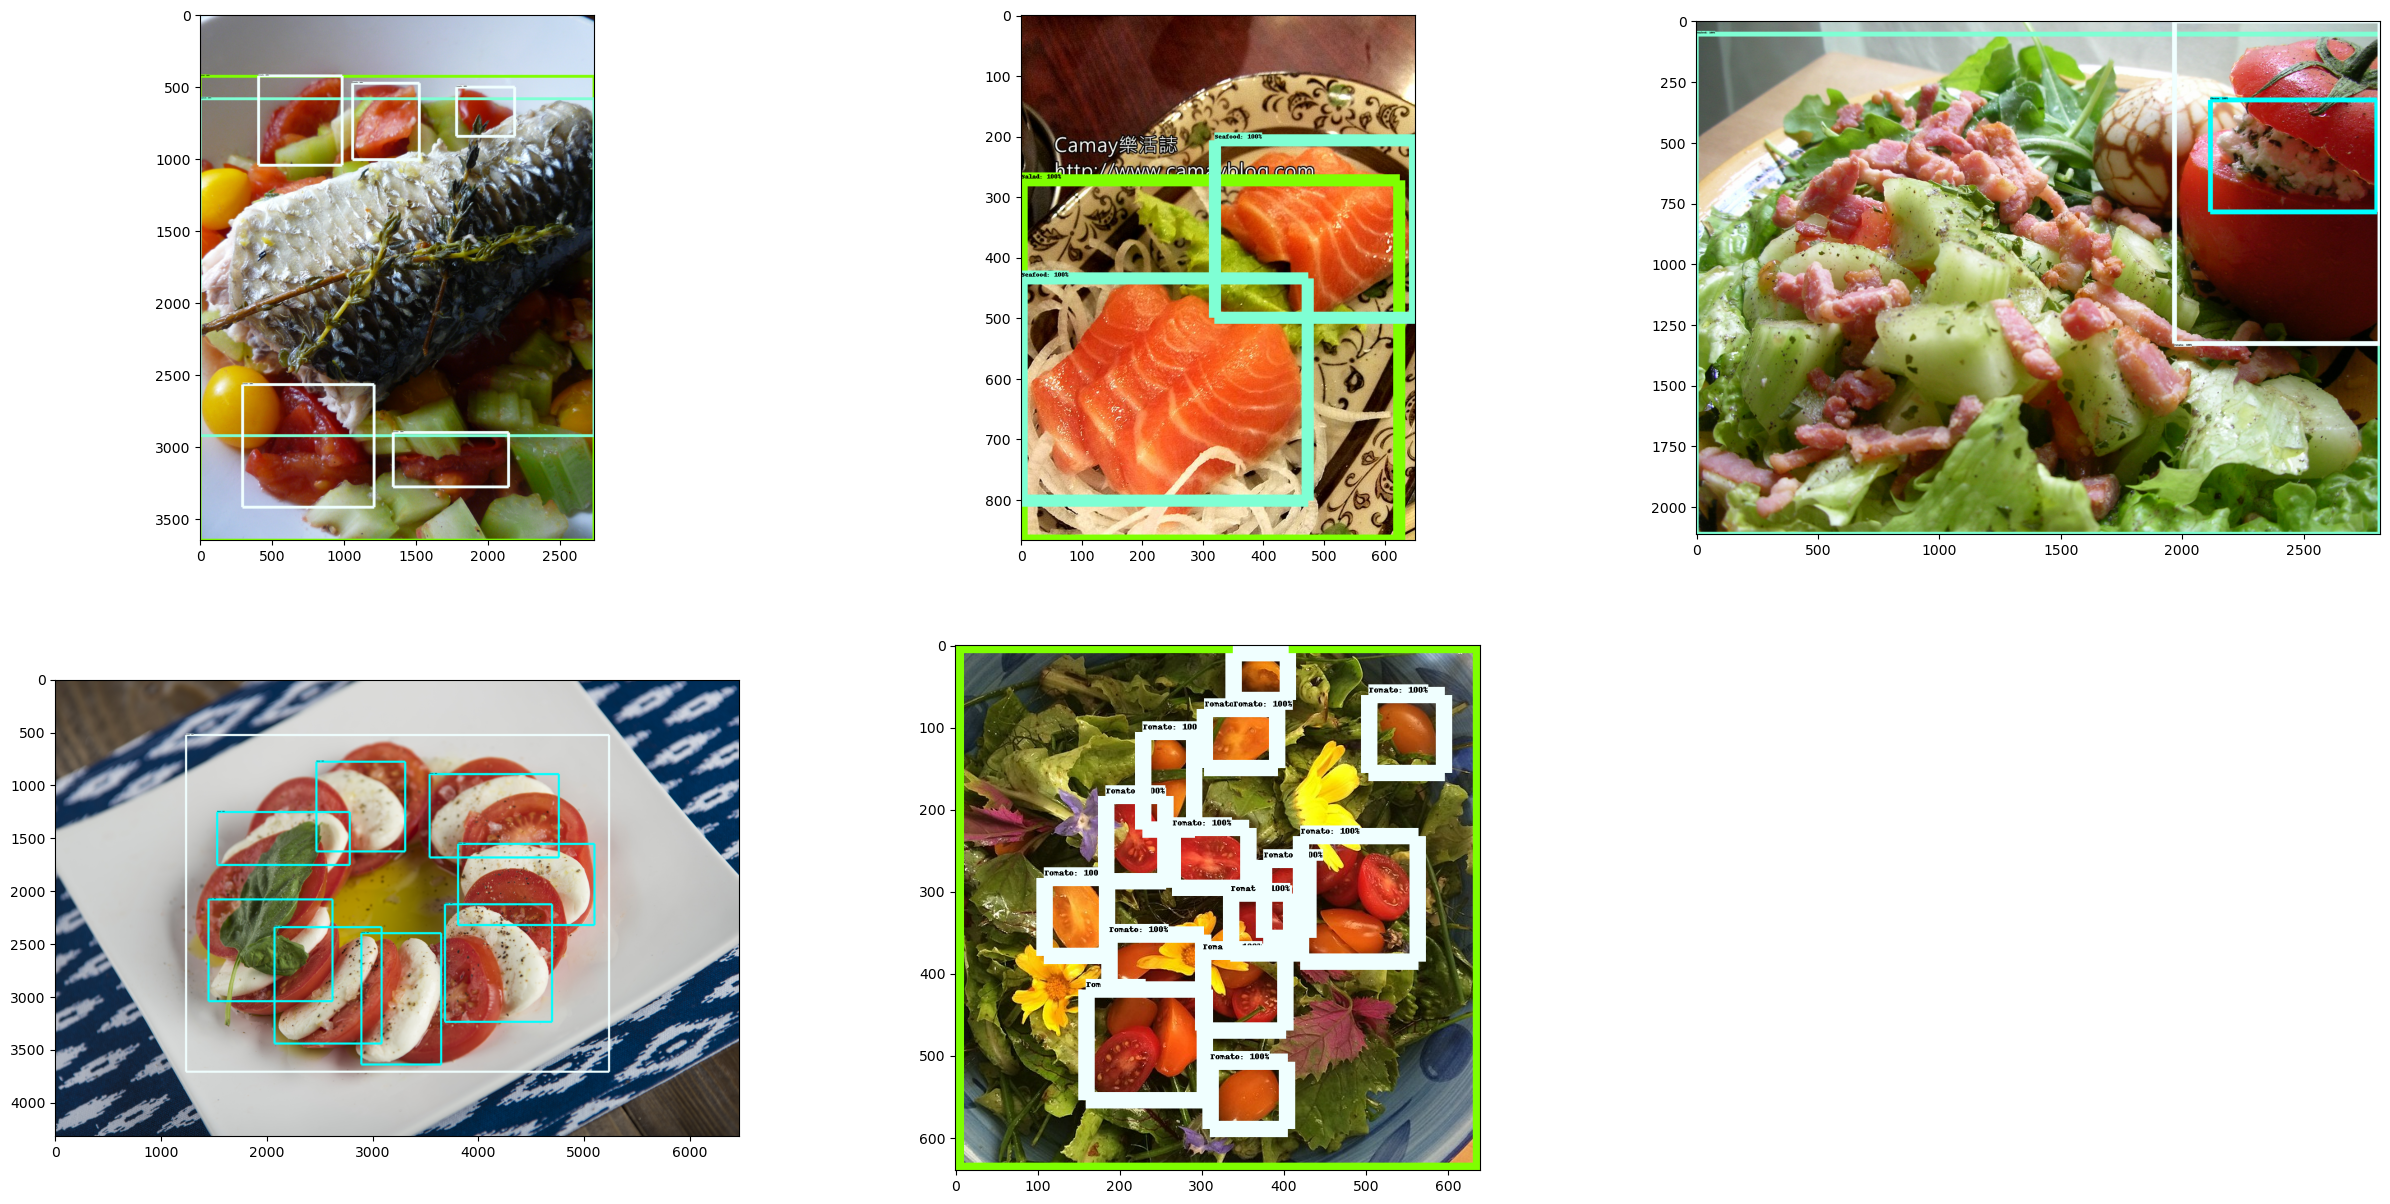

In [26]:
plt.figure(figsize=(30, 15))
for idx, (path, img, label, bbox) in enumerate(train_data.take(5)):
    plt.subplot(2, 3, idx + 1)
    plot_detections(
        img.numpy(),
        bbox.numpy(),
        label.numpy(),
        [1] * label.shape[0],  # give boxes a score of 100%
        category_index,
    )
plt.show()

Though the ground truth quality is not perfect (due to a poor labeling process), now we can see the data preprocessing is successfully done, and bounding boxes are shown around objects.

If you can not see any bounding boxes in some images, that is because only one bounding box for entire images (i.e., `[0,0,1,1]`) is assigned for the images, and it is not appropriately visualized.

## Object Detection Model
Now our data is ready. Let's build an object detection model to train.<br>
TensorFlow Object Detection API provides many useful tools, including [Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md), a collection of detection models pre-trained on [the COCO 2017 dataset](https://cocodataset.org/#home).

In this lab, we use a single stage detection with Resnet 50 v1 FPN feature extractor (a.k.a. RetinaNet) designed for 640x640 sized images. Under the Model Zoo repository, it is named as`"SSD ResNet50 V1 FPN 640x640 (RetinaNet50)"`

RetinaNet paper: https://arxiv.org/abs/1708.02002

### Download Pre-trained Weights
Let's retrieve the weights 
From [the Model Zoo page](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md), you can check the URL of each pre-trained weight file in tar.gz format (Right click the model name -> Copy Link Address). 

In [13]:
WEIGHT_FILE_PREFIX = (
    "http://download.tensorflow.org/models/object_detection/tf2/20200711"
)
MODEL_NAME = "ssd_resnet50_v1_fpn_640x640_coco17_tpu-8"

# Download the weights file
!wget {WEIGHT_FILE_PREFIX}/{MODEL_NAME}.tar.gz
!tar -xf{MODEL_NAME}.tar.gz

--2022-10-19 07:11:15--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.4’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  88.2MB/s    in 2.6s    

2022-10-19 07:11:18 (88.2 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.4’ saved [244817203/244817203]



### Setup a Model
We don't need to set up the model from scratch. Instead, we only need to load a [config file](./ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config) for the specific model.

In [14]:
# tf.keras.backend.clear_session()

pipeline_config = f"{MODEL_NAME}/pipeline.config"
!head -30 $pipeline_config

model {
  ssd {
    num_classes: 90
    image_resizer {
      fixed_shape_resizer {
        height: 640
        width: 640
      }
    }
    feature_extractor {
      type: "ssd_resnet50_v1_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 0.00039999998989515007
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.029999999329447746
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513


Let's load pipeline config using `config_util.get_configs_from_pipeline_file()` and modify a little.

Since we are working off of a [COCO](https://cocodataset.org/#home) architecture which predicts 90 class slots by default, we override the `num_classes` field here to be just 5 (for our new salad datasets).

Then, we can build a model with `model_builder.build()`.

In [15]:
configs = config_util.get_configs_from_pipeline_file(pipeline_config)

model_config = configs["model"]
model_config.ssd.num_classes = len(CLASSES)

detection_model = model_builder.build(
    model_config=model_config, is_training=True
)

Run the model through a dummy image so that variables are created.

In [16]:
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)

2022-10-19 07:11:22.974579: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


## Training

### Restore Pretrained Weights
Instead of training `detection_model` from scratch, we restore weights from the pre-trained checkpoint file and run transfer learning.

Let's set up object-based checkpoint restore using `tf.train.Checkpoint` where we can specify the objects we want to checkpoint as attributes on the object. <br>

At first, we restore the 'heads' of the detection model. RetinaNet has two prediction 'heads' --- one for classification and the other for box regression.<br>
We will restore the box regression head but initialize the classification head from scratch (we show the omission below by commenting out the line that we would add if we wanted to restore both heads)

In [17]:
checkpoint_path = f"{MODEL_NAME}/checkpoint/ckpt-0"

box_predictor_ckpt = tf.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
)

Next, we set up another checkpoint object for the entire model and restore all variables.

In order to silence warnings about incomplete checkpoint restores, we also add `expect_partial()` when we call `tf.train.Checkpoint.restore()`.

In [18]:
model_ckpt = tf.train.Checkpoint(
    _feature_extractor=detection_model._feature_extractor,
    _box_predictor=box_predictor_ckpt,
)

ckpt = tf.train.Checkpoint(model=model_ckpt)
ckpt.restore(checkpoint_path).expect_partial()

### Transfer Learning

In transfer learning, we reuse the knowledge our model learned from pretraining and update the heads only.

To specify which variable should/should not be updated, let's create a list of the variables for the two detection heads (`to_fine_tune`).<br>

In [19]:
trainable_variables = detection_model.trainable_variables

to_fine_tune = []

prefixes_to_train = [
    "WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead",
    "WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead",
]

for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

Now let's define the training loop that will:
- provide ground truth label data to the model using `provide_groudtruth` to compute loss value later
- call `model.predict` and get the result dictionary
- call `model.loss` to compute loss values and sum up box regression loss (`localization_loss`) and classification loss (`classification_loss`)
- update the targeted variables using the computed loss value

RetinaNet uses the standard smooth L1 loss for box regression task and focal loss for classification task.<br>
For details, please refer to the [original paper](https://arxiv.org/abs/1708.02002).

In [20]:
def train_step_fn(
    image_tensors,
    groundtruth_boxes_list,
    groundtruth_classes_list,
    batch_size,
):
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)

    detection_model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list,
    )

    with tf.GradientTape() as tape:
        prediction_dict = detection_model.predict(image_tensors, shapes)
        losses_dict = detection_model.loss(prediction_dict, shapes)
        total_loss = (
            losses_dict["Loss/localization_loss"]
            + losses_dict["Loss/classification_loss"]
        )
        gradients = tape.gradient(total_loss, to_fine_tune)
        optimizer.apply_gradients(zip(gradients, to_fine_tune))
    return total_loss

Before running training, let's apply the preprocessing for training data like resizing and rescaling.<br>
Instead of writing the logic by ourselves, we can use the predefined `model.preprocess()` via Object Detection API.

In [21]:
def _preprocess(path, img, label, bbox):
    label = tf.one_hot(label, len(CLASSES))

    img = tf.expand_dims(img, axis=0)
    img = tf.cast(img, tf.float32)
    img = detection_model.preprocess(img)[0]
    img = tf.squeeze(img, axis=0)
    return path, img, label, bbox


preprocessed_train_data = train_data.map(_preprocess)

Now let's iterate over training data and update the selected weights.

This will take 20 minutes with one NVIDIA T4 GPU.

In [22]:
NUM_SAMPLES = TRAIN_SIZE
BATCH_SIZE = 1
EPOCHS = 20
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

print("Start fine-tuning!", flush=True)

total_loss = []
for idx, (path, img, label, bbox) in enumerate(
    preprocessed_train_data.batch(BATCH_SIZE).repeat(EPOCHS)
):
    progress_percent = (idx % NUM_SAMPLES) / NUM_SAMPLES * 100

    total_loss.append(train_step_fn(img, bbox, label, BATCH_SIZE))

    if idx != 0:
        if idx % NUM_SAMPLES == 0:
            print("")
        else:
            current_epoch = idx // NUM_SAMPLES + 1
            current_loss = np.mean(total_loss[idx - (idx % NUM_SAMPLES) : idx])
            print(
                (
                    f"epoch {current_epoch:<2}/{EPOCHS},"
                    f"loss: {current_loss:.4f},"
                    f"[{'■' * (math.ceil(progress_percent) // 5): <20}]"
                    f"{math.ceil(progress_percent)}%"
                ),
                end="\r",
                flush=True,
            )

print("")
print("Done fine-tuning!")

Start fine-tuning!
epoch 1 /20, loss: 0.9197 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 2 /20, loss: 0.7947 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 3 /20, loss: 0.7313 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 4 /20, loss: 0.7441 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 5 /20, loss: 0.7224 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 6 /20, loss: 0.7102 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 7 /20, loss: 0.6873 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 8 /20, loss: 0.6639 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 9 /20, loss: 0.7065 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 10/20, loss: 0.6322 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 11/20, loss: 0.6576 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 12/20, loss: 0.6179 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 13/20, loss: 0.6318 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 14/20, loss: 0.6352 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 15/20, loss: 0.6243 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 16/20, loss: 0.6055 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 17/20, loss: 0.6286 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 18/20, loss: 0.6003 [■■■■■■■■■■■■■■■■■■■■] 100%
epoch 19/

## Detection
Let's try to detect bounding boxes over the test data, and check if the transfer learning went well.

In object detection, we need to apply complex postprocessing, including non-max suppression (NMS), to the prediction outputs.<br>
But you don't need to implement it from scratch. The Object Detection has a predefined `model.postprocess` method we can easily use.

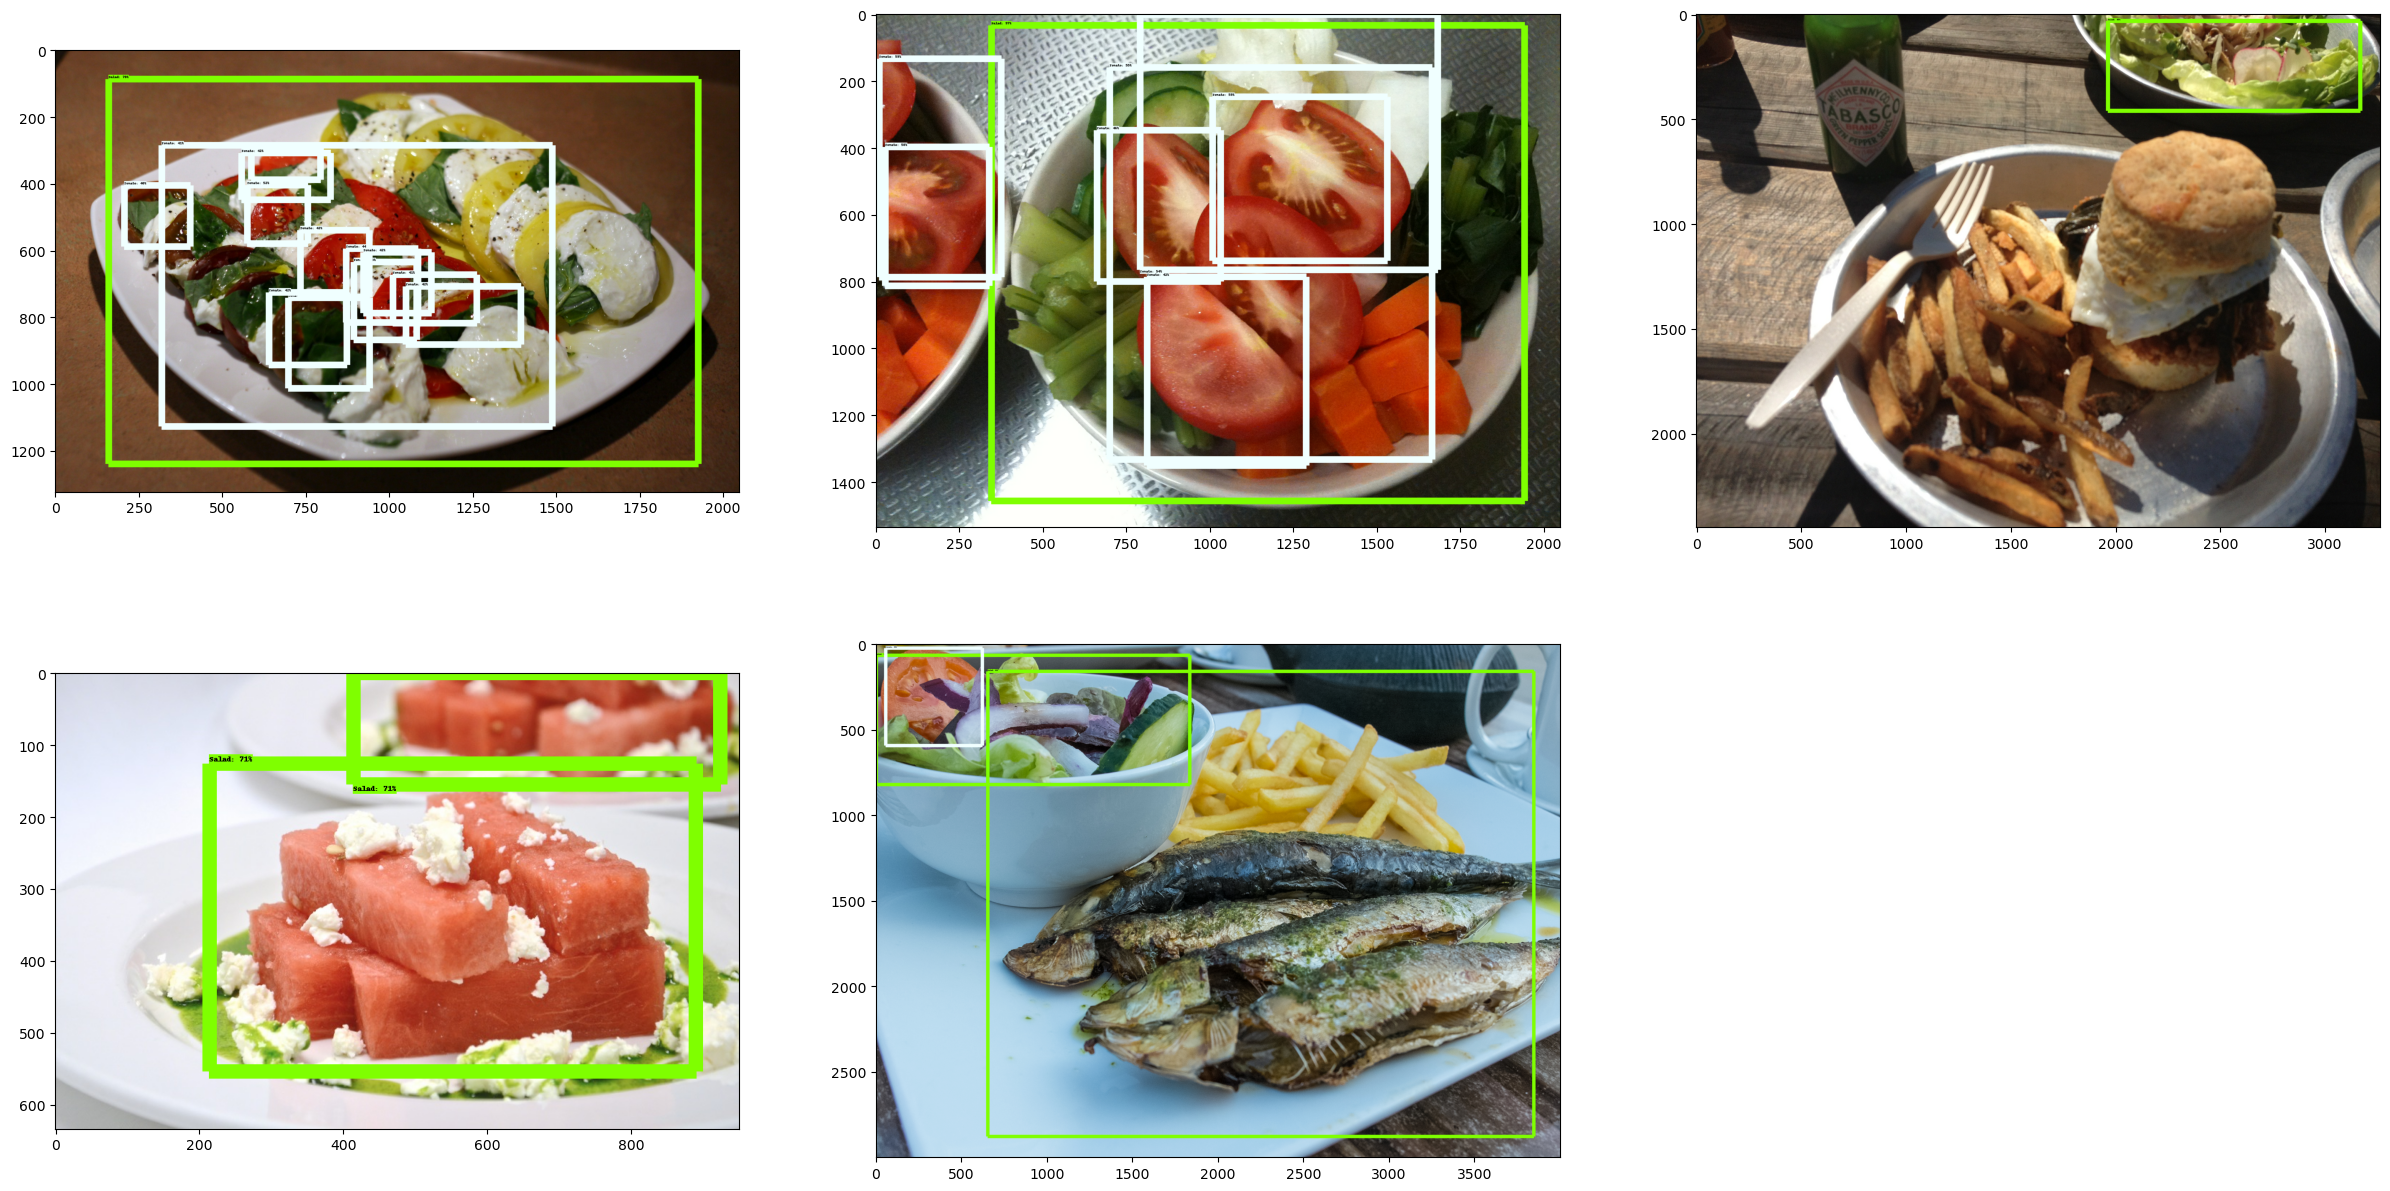

In [23]:
plt.figure(figsize=(30, 15))

for idx, (path, img, label, bbox) in enumerate(test_data.take(5)):
    plt.subplot(2, 3, idx + 1)

    _, preprocessed_img, _, _ = _preprocess(path, img, label, bbox)
    prediction_dict = detection_model.predict(
        tf.expand_dims(preprocessed_img, axis=0), shapes
    )
    detections = detection_model.postprocess(prediction_dict, shapes)

    plot_detections(
        img.numpy(),
        detections["detection_boxes"][0].numpy(),
        detections["detection_classes"][0].numpy().astype(np.uint32),
        detections["detection_scores"][0].numpy(),
        category_index,
    )

plt.show()

Still not perfect, but we can see our model is tuned toward our own salad dataset successfully.

Here are a few ideas to improve the performance:
- Improve the dataset label quality
- Add more data
- Tune learning rate and scheduling strategy
- Train longer time

## Summary
In this notebook, we learned how to build and train an object detection model using the Tensorflow Object Detection API.


## License

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License